# Resolución de problema de clasificación

## 1. Carga de datos e importación de librerías

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier, ExtraTreesClassifier, IsolationForest, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer, PolynomialFeatures

from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#TODO Introducir el dataset con el que se vaya a trabajar
df = pd.read_csv('diamonds.csv')

#! OBTENCIÓN DE UNA MUESTRA SI EL DATASET ES MUY GRANDE
df = df.sample(n=1000, random_state=42)
df.head()



,carat,cut,color,clarity,depth,table,price,x,y,z
1388,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
50052,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
41645,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
42377,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
17244,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


## 2. Exploratory data analysis (EDA)

0. Exploracion del dataset (info, describe, shape)
1. Realizar un histplot para tener una noción general.
2. Realizar un gráfico controlando los categóricos, después los exploraremos en mayor porfundida (sns.countplot())
3. Realizar un heatmap para ver correlaciones.
4. Realizar un scatterpolot para explorar las correlaciones vistas.
5. Utiliza boxplot para ver la dispersión de los datos y detectar Outliers.

In [2]:
print('Shape: ', df.shape)
#Obtenemos información sobre el tipo de dato y los nulos por columna
df.info()

Shape:  (1000, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1388 to 21429
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    1000 non-null   float64
 1   cut      1000 non-null   object 
 2   color    1000 non-null   object 
 3   clarity  1000 non-null   object 
 4   depth    1000 non-null   float64
 5   table    1000 non-null   float64
 6   price    1000 non-null   int64  
 7   x        1000 non-null   float64
 8   y        1000 non-null   float64
 9   z        1000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 85.9+ KB


In [3]:
#
#TODO Separamos los categóricos de los numéricos

categorical_features = ['cut', 'color', 'clarity']
numerical_features = ['carat','depth', 'table', 'price', 'x', 'y', 'z']

#TODO Definimos la columna de salida
target = 'cut'

### Visualización del dataset 


array([[<Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>,
        <Axes: title={'center': 'table'}>],
       [<Axes: title={'center': 'price'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >, <Axes: >]], dtype=object)

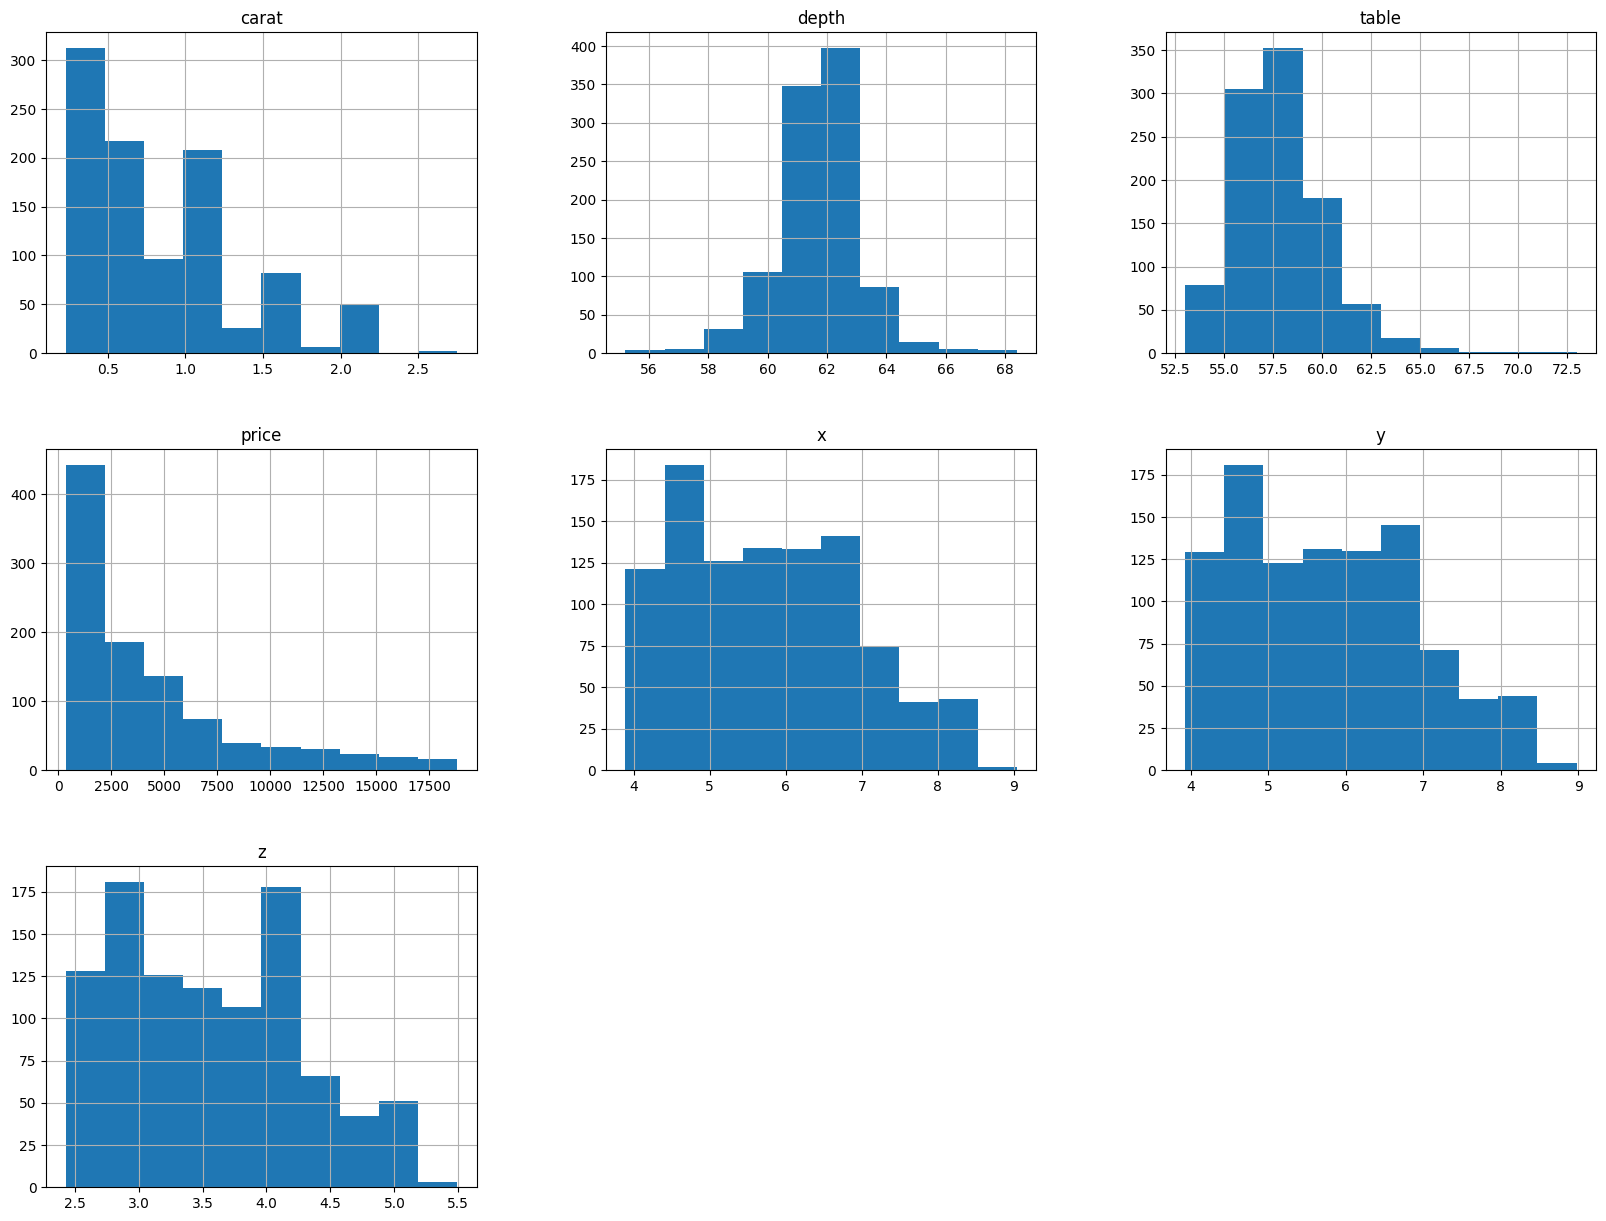

In [4]:
df.hist(figsize=(20, 15))

### Exploración de los categóricos

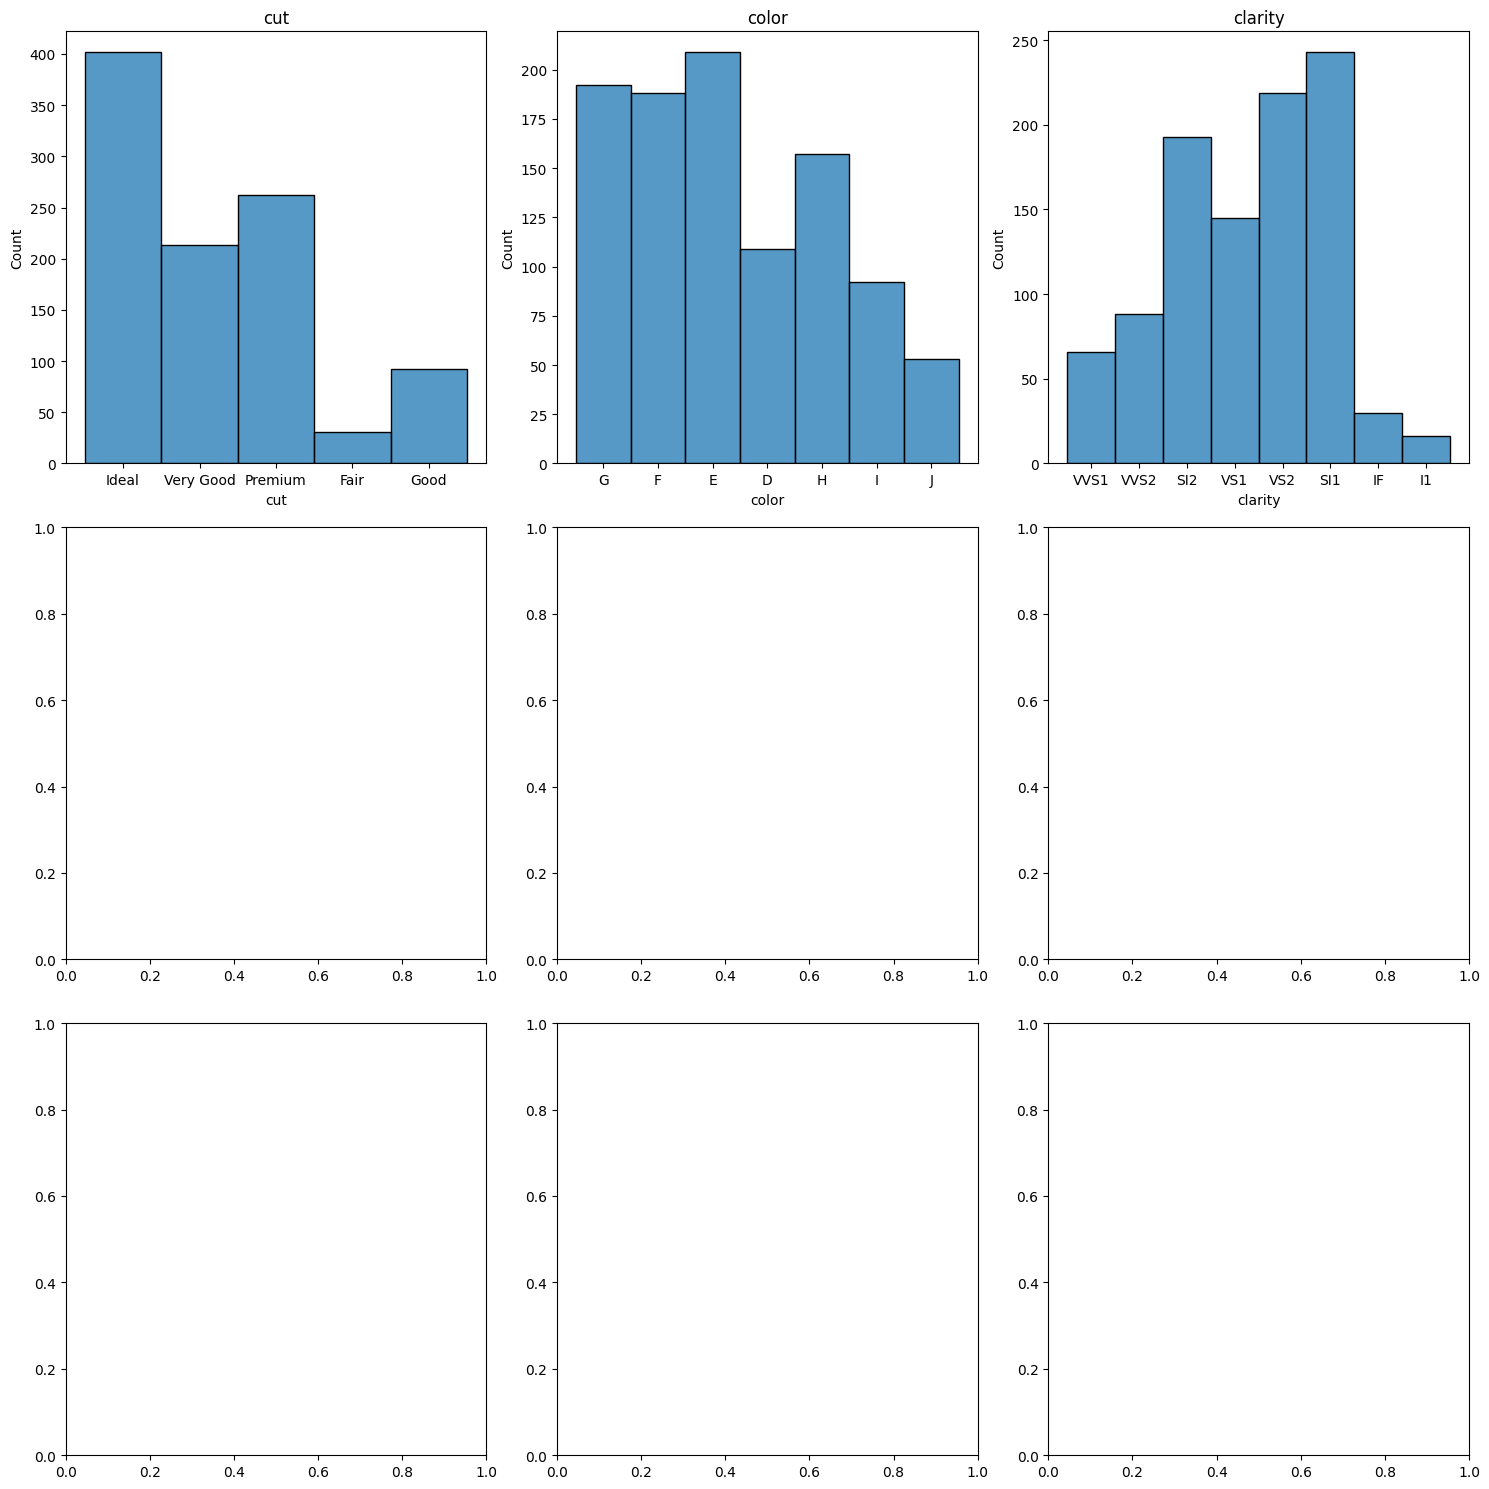

In [5]:
#
#TODO Simplificar la visiualización de los categóricos
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, feature in enumerate(categorical_features):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    ax.set_title(feature)
    sns.histplot(df[feature],  ax=ax)

plt.tight_layout()
plt.show()


### Exploración de correlaciones

In [6]:
#TODO Codificación de los categóricos para la matriz de correlación


one_hot_encoder = OneHotEncoder(drop='first', sparse_output=True)
encoded_data = one_hot_encoder.fit_transform(df[categorical_features])

encoded_data = encoded_data.toarray()
#Nombres de las columnas
feature_names = one_hot_encoder.get_feature_names_out()

#Creamos un dataframe con los datos codificados
df_encoded = pd.DataFrame(encoded_data, columns=feature_names)
df_encoded

,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
997,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<Axes: title={'center': 'Matriz de correlación'}>

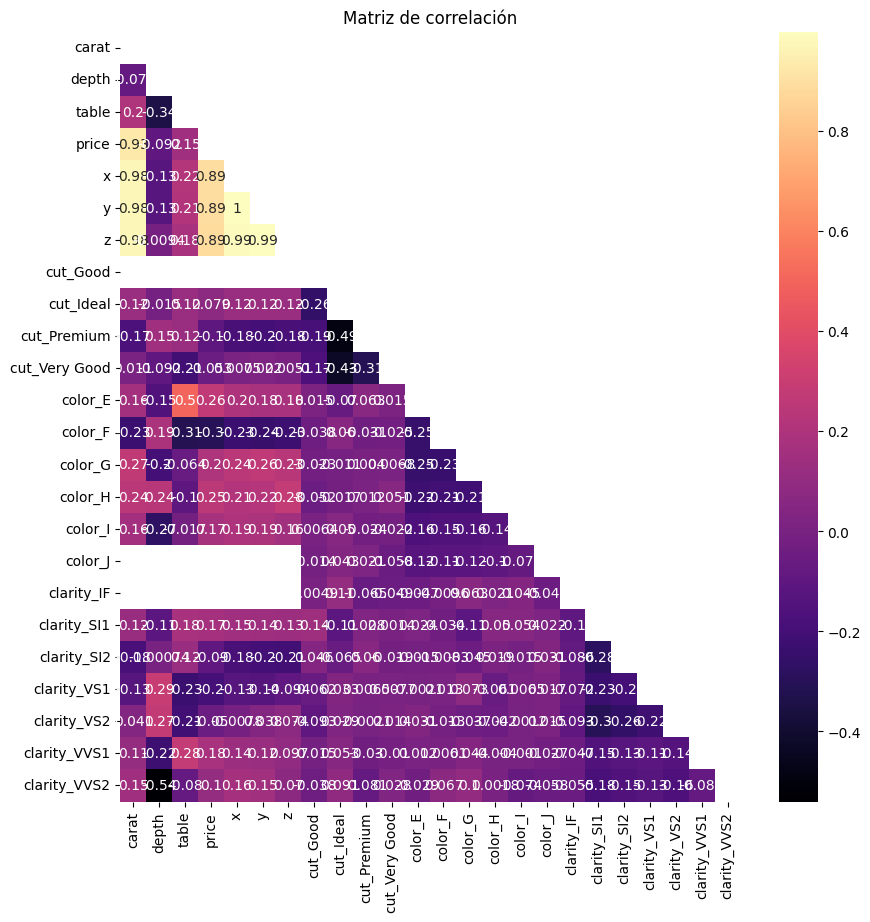

In [7]:
#
#TODO Meter correlaciones con los categóricos

# Concatenar el DataFrame codificado con el DataFrame original
df_combined = pd.concat([df.drop(categorical_features, axis=1), df_encoded], axis=1)

# Calcular la matriz de correlación
df_corr = df_combined.corr()

# Crear una máscara para la mitad superior de la matriz de correlación
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Dibujar el mapa de calor
plt.figure(figsize=(10, 10))
plt.title('Matriz de correlación')
sns.heatmap(df_corr, mask=mask, annot=True, cmap='magma')

### Scatterplot para profundizar en las correlaciones

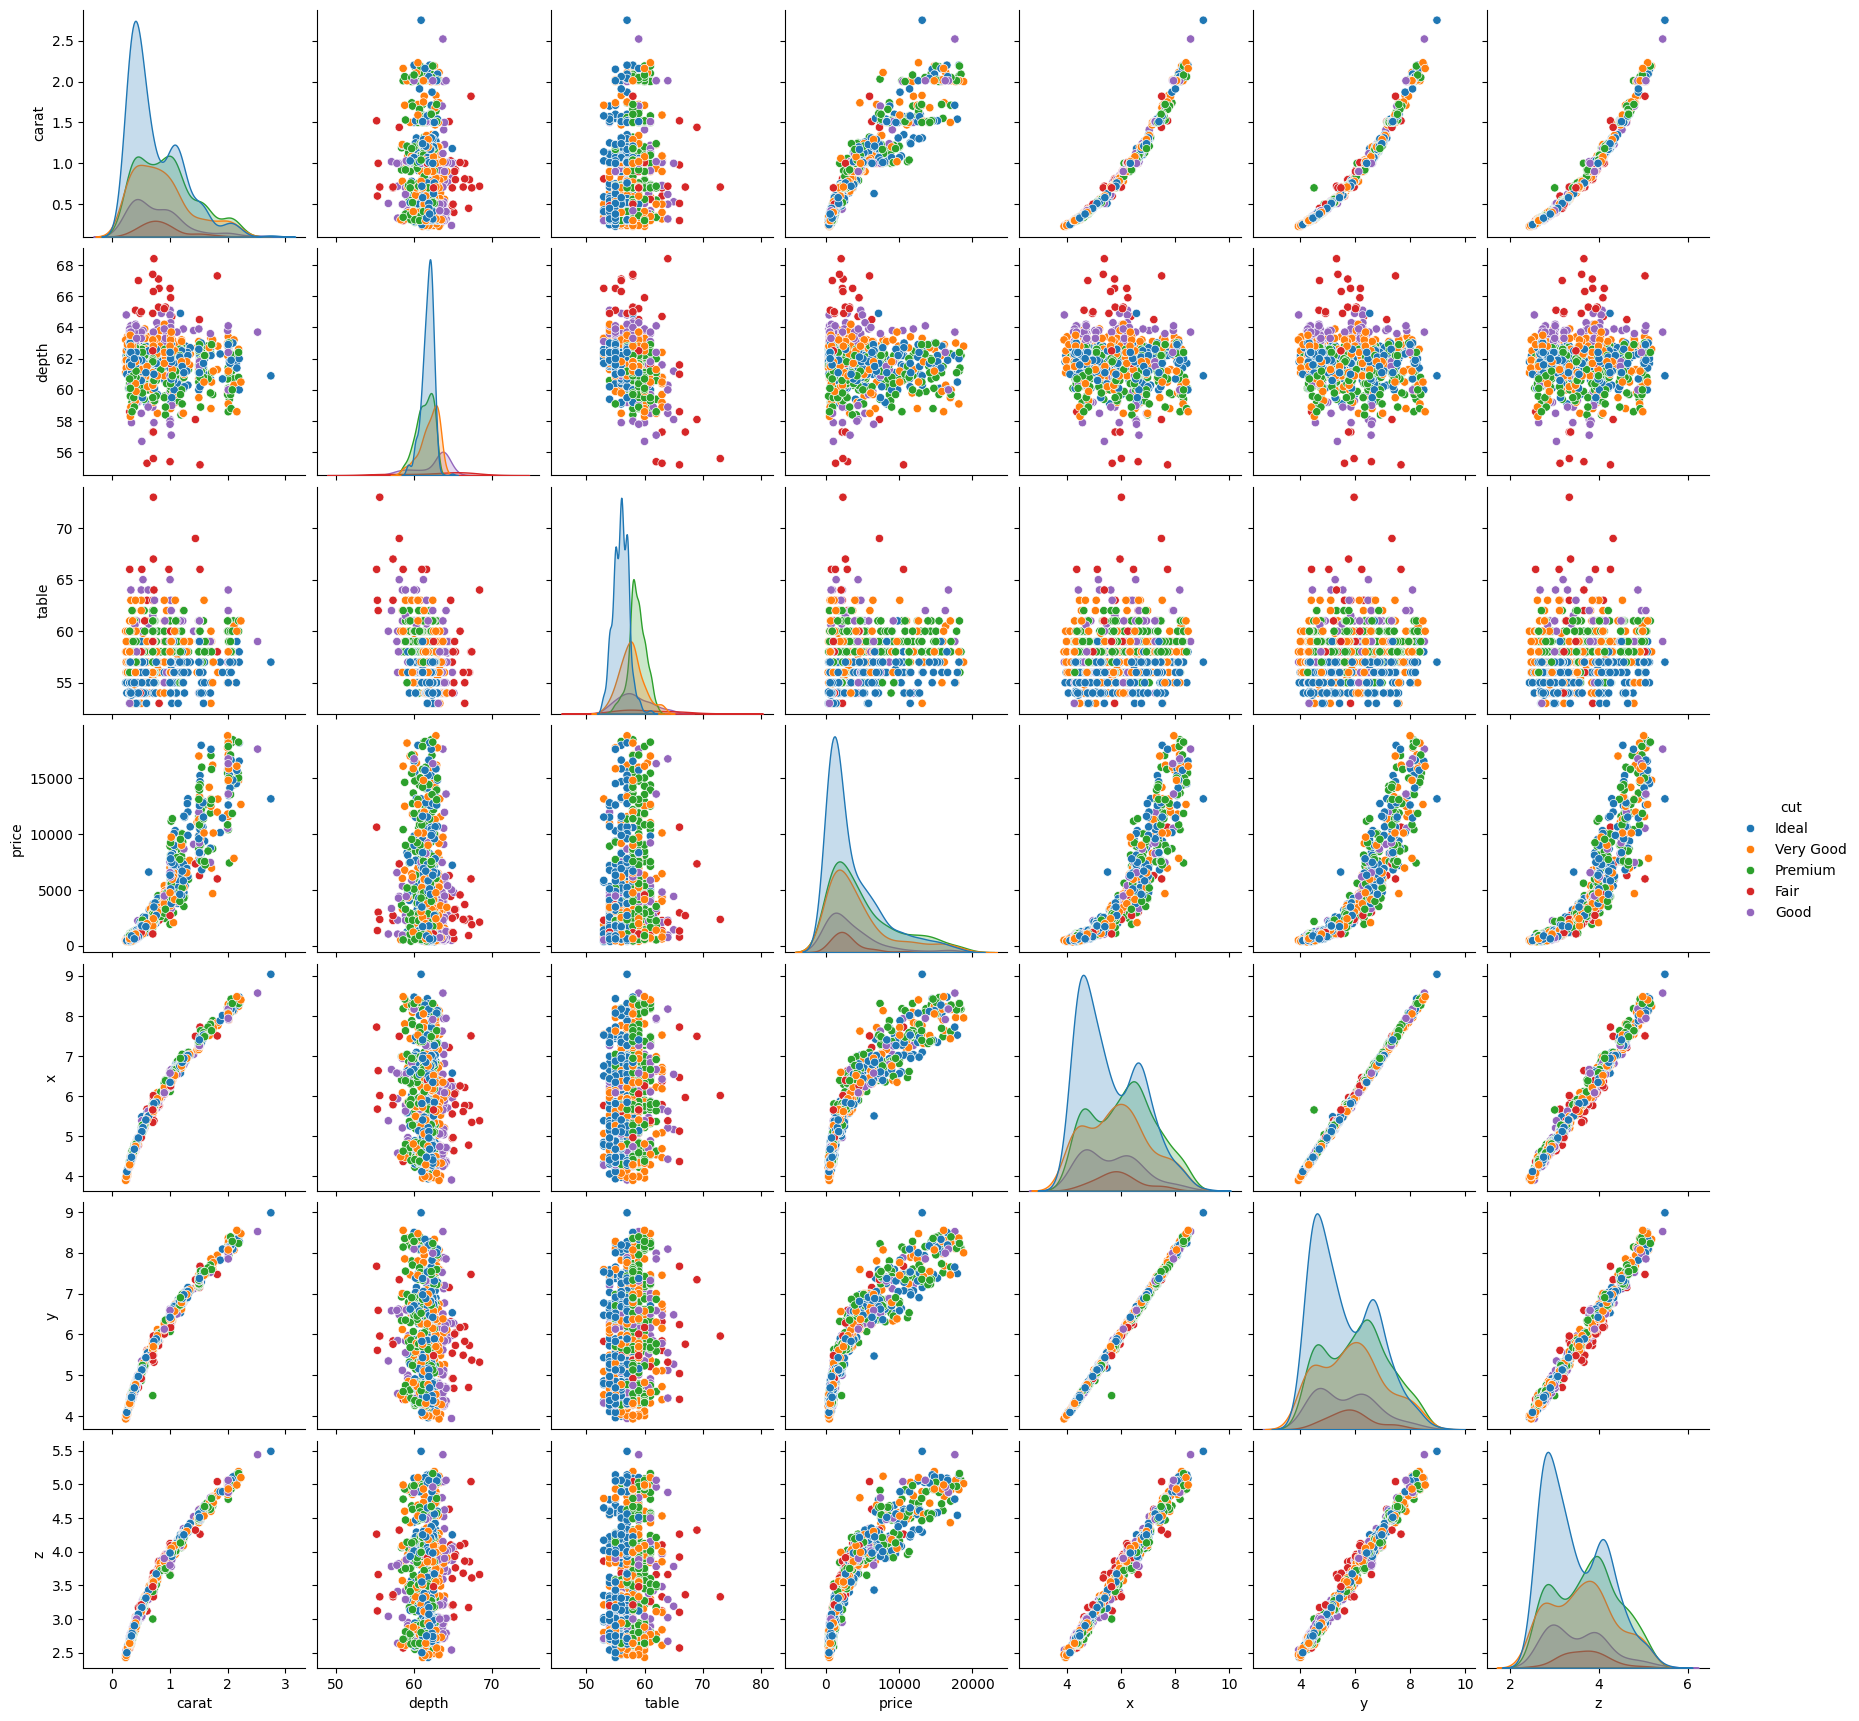

In [8]:
#
# TODO Introducir el nombre de las columnas que se van a utilizar para predecir, añadir una categórica en hue

# SI NECESITAS VER UNA RELACIÓN MUY CONCRETA UTILIZA ESTE OTRO:
#sns.scatterplot(data=df, x='sepal_length', y='sepal_width', hue='species')

#Para ver todas las relaciones posibles
sns.pairplot(df, hue=target)

### Boxplot: distribución de datos y detección de Outliers

Text(0.5, 1.0, 'Boxplot para detectar outliers')

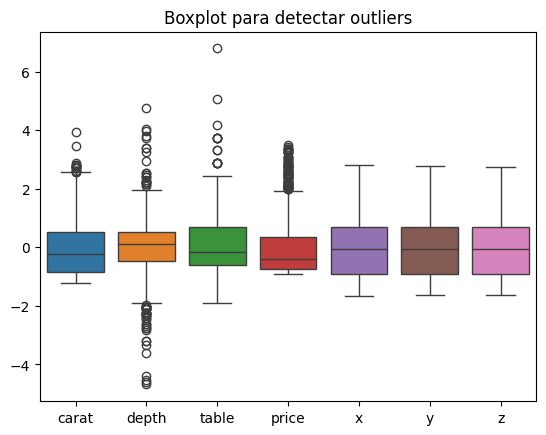

In [9]:
standar_scaler = StandardScaler()
df_scaled = standar_scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

#boxplot de una columna con categoría
#sns.boxplot(data=df, x='species', y='sepal_length')

#Boxplot de todas las columnas

sns.boxplot(data=df_scaled)
plt.title('Boxplot para detectar outliers')

## 3. Preparación de las métricas de validación

In [10]:
categorical_features = [feature for feature in categorical_features if feature != 'cut']

In [11]:

#TODO Eliminamos temporalmente los NAN y los valores no numéricos.

df_dropnan = df.dropna()

X_dropnan = df_dropnan.drop([target], axis=1)
encoder = OrdinalEncoder()
X_dropnan[categorical_features] = encoder.fit_transform(X_dropnan[categorical_features])
y_dropnan = df_dropnan[target]

y_numerical = LabelEncoder().fit_transform(y_dropnan)


In [12]:
X_dropnan

,carat,color,clarity,depth,table,price,x,y,z
1388,0.24,3.0,6.0,62.1,56.0,559,3.97,4.00,2.47
50052,0.58,2.0,7.0,60.0,57.0,2201,5.44,5.42,3.26
41645,0.40,1.0,7.0,62.1,55.0,1238,4.76,4.74,2.95
42377,0.43,1.0,7.0,60.8,57.0,1304,4.92,4.89,2.98
17244,1.55,1.0,3.0,62.3,55.0,6901,7.44,7.37,4.61
...,...,...,...,...,...,...,...,...,...
35207,0.33,5.0,1.0,61.6,55.0,891,4.47,4.46,2.75
15806,1.00,1.0,2.0,62.4,55.0,6324,6.34,6.42,3.98
45884,0.58,3.0,5.0,61.1,56.0,1719,5.40,5.43,3.31
22681,0.38,6.0,7.0,62.0,55.0,629,4.67,4.69,2.90


In [33]:


#TODO PARA PROBLEMAS DE CLASIFICACIÓN (FALTA LA MATRIZ DE CONFUSIÓN)

def calc_predictions(X, y):
    """
    Accuracy: ¿cuántos acierta?
    Precision : ¿Está detectando todos los positivos o deja alguno fuera?
    Recall o sensibilidad: ¿de todos los positivos, cuántos son positivos de verdad? (está colando muchos falsos positivos?)
    F1-score: ¿Puedo combinar Precision y Recall en una sola métrica?
    """
    df_results = pd.DataFrame(columns=['model_name', 'accuracy', 'recall', 'f1_score', 'overall_f1_score'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    models = [
        LogisticRegression(max_iter=1000),
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(kernel='rbf', C=100, gamma=0.1), 
    ]

    for model in models:
        # entrenamiento y predicciones
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # classification metrics
        model_name = model.__class__.__name__
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        overall_f1 = f1_score(y_test, y_pred, average='weighted')

        # guardar resultados
        row = [model_name, accuracy, recall, f1, overall_f1]
        df_results.loc[len(df_results)] = row

    return df_results

calc_predictions(X_dropnan, y_numerical)

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.552,0.310913,0.266599,0.464430
1,KNeighborsClassifier,0.388,0.242796,0.225344,0.354232
2,DecisionTreeClassifier,0.584,0.608393,0.604724,0.589112
3,RandomForestClassifier,0.668,0.576954,0.618779,0.654208
4,SVC,0.376,0.211780,0.158781,0.257973


## 4. Preprocesado de datos
1. Tratar valores faltantes o nulos.
2. Transformación de categóricos a numéricos (OrdinalEncoder-entrada // LabelEncoder-salida)
3. Tratar Outliers -si procede... muchas veces vamos a necesitarlos.

4. Escalar datos (estandarizar o normalizar)
5. Reducir dimensionalidad del dataset (eliminacion de features SelectKBest)

6. Creación de nuevas features significativas.
7. Discretización de datos -binarizar o kbins.
8. Corregir distribucion de datos y sesgos.

9. Observar si los datos están desbalanceados -demasiadas muestras de uno y pocos de otro.

### Tratar valores faltantes

Comprobamos dónde están los valores faltantes dentro del dataframe. Opcionalmente, podríamos utilizar df.info() si quisiéramos saber cuántos registros tienen valores para cada columna. 

In [34]:
df_copy = df.copy()
df_copy.isnull().sum()


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [35]:
df_imputed = df.copy()
#df_imputed.drop(['embark_town', 'deck'], axis=1, inplace=True)

# #TODO Elegir el tipo de IMPUTER que se va a utilizar
# simple_imputer = SimpleImputer(strategy='most_frequent')
# imputer = KNNImputer()
# #imputer = IterativeImputer()

# #TODO IMPUTACIÓN DE LOS NUMÉRICOS
# df_imputed_col = pd.DataFrame(df_imputed[target])
# imputer.fit(df_imputed_col)
# df_imputed[target] = imputer.transform(df_imputed_col)
# df_imputed[target] = df_imputed[target].astype('float64')


# df_imputed_col = pd.DataFrame(df_imputed['age'])
# imputer.fit(df_imputed_col)
# df_imputed['age'] = imputer.transform(df_imputed_col)
# df_imputed['age'] = df_imputed['age'].astype('float64')


# #TODO IMPUTACIÓN DE LOS CATEGÓRICOS
# df_imputed_col= pd.DataFrame(df_imputed['embarked'])
# simple_imputer.fit(df_imputed_col)
# df_imputed['embarked'] = simple_imputer.transform(df_imputed_col).flatten()
# df_imputed['embarked'] = df_imputed['embarked']

# Verificamos que ya no hay nulos
print(df_imputed.isnull().sum())
df_imputed.info()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1388 to 21429
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    1000 non-null   float64
 1   cut      1000 non-null   object 
 2   color    1000 non-null   object 
 3   clarity  1000 non-null   object 
 4   depth    1000 non-null   float64
 5   table    1000 non-null   float64
 6   price    1000 non-null   int64  
 7   x        1000 non-null   float64
 8   y        1000 non-null   float64
 9   z        1000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 118.2+ KB


In [36]:
X = df_imputed.drop([target], axis=1)
X

,carat,color,clarity,depth,table,price,x,y,z
1388,0.24,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
50052,0.58,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
41645,0.40,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
42377,0.43,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
17244,1.55,E,SI2,62.3,55.0,6901,7.44,7.37,4.61
...,...,...,...,...,...,...,...,...,...
35207,0.33,I,IF,61.6,55.0,891,4.47,4.46,2.75
15806,1.00,E,SI1,62.4,55.0,6324,6.34,6.42,3.98
45884,0.58,G,VS2,61.1,56.0,1719,5.40,5.43,3.31
22681,0.38,J,VVS2,62.0,55.0,629,4.67,4.69,2.90


In [42]:
#
#TODO Si te has cargado alguna columna, escribela en esta lista
cols_to_remove = ['embark_town', 'deck']

categorical_features = [cat for cat in categorical_features if cat not in cols_to_remove]

#COMPROBACIÓN DE MÉTRICAS DE EVALUACIÓN
X = df_imputed.drop([target], axis=1)
X[categorical_features] = OrdinalEncoder().fit_transform(df_imputed[categorical_features])
y = LabelEncoder().fit_transform(df_imputed[target])


calc_predictions(X,y)

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.552,0.310913,0.266599,0.464430
1,KNeighborsClassifier,0.388,0.242796,0.225344,0.354232
2,DecisionTreeClassifier,0.600,0.592126,0.602784,0.607548
3,RandomForestClassifier,0.688,0.604583,0.645049,0.671049
4,SVC,0.376,0.211780,0.158781,0.257973


### Convertir categóricos a numéricos

Puesto que algunos métodos para tratar Outliers son sensibles a los categóricos, vamos a proceder a convertirlos en numéricos ahora. Disponemos de los siguientes métodos:

-get_dummies : método genérico de pandas. Sobredimensiona el df con demasiadas columnas. No recomendable.

-LabelEncoder : clase de ScikitLearn para datos de salida.

-OrdinalEncoder: clase de scikitLearn para datos de entrada.

-OneHotEncoder : crear columnas con 0 y 1 para indicar si la categoría es o no. Puede sobredimensionar el dataset... así que de momento no vamos a utilizarlo mucho.

In [46]:
#Utilizaremos el ordinal encoder para transformar la columna categórica a numérica en la X

ordinal_encoder = OrdinalEncoder()

df_2 = df_imputed.copy()
df_2[categorical_features] = ordinal_encoder.fit_transform(df_2[categorical_features])
df_2[target] = LabelEncoder().fit_transform(df_imputed[target])


X = df_2.drop(target, axis=1) 
y = df_2[target]
calc_predictions(X,y)

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.552,0.310913,0.266599,0.464430
1,KNeighborsClassifier,0.388,0.242796,0.225344,0.354232
2,DecisionTreeClassifier,0.600,0.611693,0.621324,0.603728
3,RandomForestClassifier,0.692,0.610166,0.652481,0.677983
4,SVC,0.376,0.211780,0.158781,0.257973


### Identificar outliers y tratarlos (si procede)
CONSIDERACIONES:
1. El IQR es para datos univariantes. Si vas a trabajar con varias columnas, usa el Isolation Forest.
2. El isolation Forest no se lleva bien con los categóricos. Asegúrate de quitarlos de este paso.
3. El Isolation Forest no trabaja con NaN ni valores faltantes. Hay que manejarlos antes de ajustar el modelo.

In [47]:
# Configurar Isolation Forest (la contaminación es la proporción de outliers esperados)
iso = IsolationForest(contamination=0.01)  

df_3 = df_2.copy()

# Elimina las columnas no relevantes para la detección de outliers.. por ejemplo los categóricos (aunque ahora sean numéricos)
df_3 = df_3.drop(columns=[target])

# Ajusta el modelo y predecir outliers
outliers = iso.fit_predict(df_3)

# Agregar resultados de outliers como una columna en el DataFrame original
df_2['outlier'] = outliers

# Filtrar outliers
df_3 = df_2[df_2['outlier'] == 1].copy()

# Eliminar la columna 'outlier' del DataFrame df_sin_outliers si no es necesaria
df_3.drop(columns=['outlier'], inplace=True)

# Verificar el tamaño de los DataFrames para asegurarse de que los outliers se eliminaron correctamente
print("Tamaño del df_2:", df_2.shape)
print("Tamaño del df_3 sin outliers:", df_3.shape)


X_3 = df_3.drop([target], axis=1)
y_3 = df_3[target] 

#TODO: EN CASO DE EMPEORAR LAS MÉTRICAS DE EVALUACIÓN, MANTENER LOS OUTLIERS
calc_predictions(X_3,y_3)

Tamaño del df_2: (1000, 11)
Tamaño del df_3 sin outliers: (990, 10)


c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.536290,0.295862,0.254725,0.448351
1,KNeighborsClassifier,0.443548,0.280308,0.271566,0.404476
2,DecisionTreeClassifier,0.560484,0.573324,0.587838,0.571828
3,RandomForestClassifier,0.653226,0.531708,0.567259,0.642521
4,SVC,0.419355,0.218966,0.172356,0.297542


### Escalar datos 
Utiliza MinMaxScaler si necesitas que todo esté entre 0-1 y no te importan los Outliers.
Utiliza StandarScaler si quieres desviación estándar de 1 y 0 de media, y SÍ te importan los Outliers.

Text(0.5, 1.0, 'Boxplot para detectar outliers')

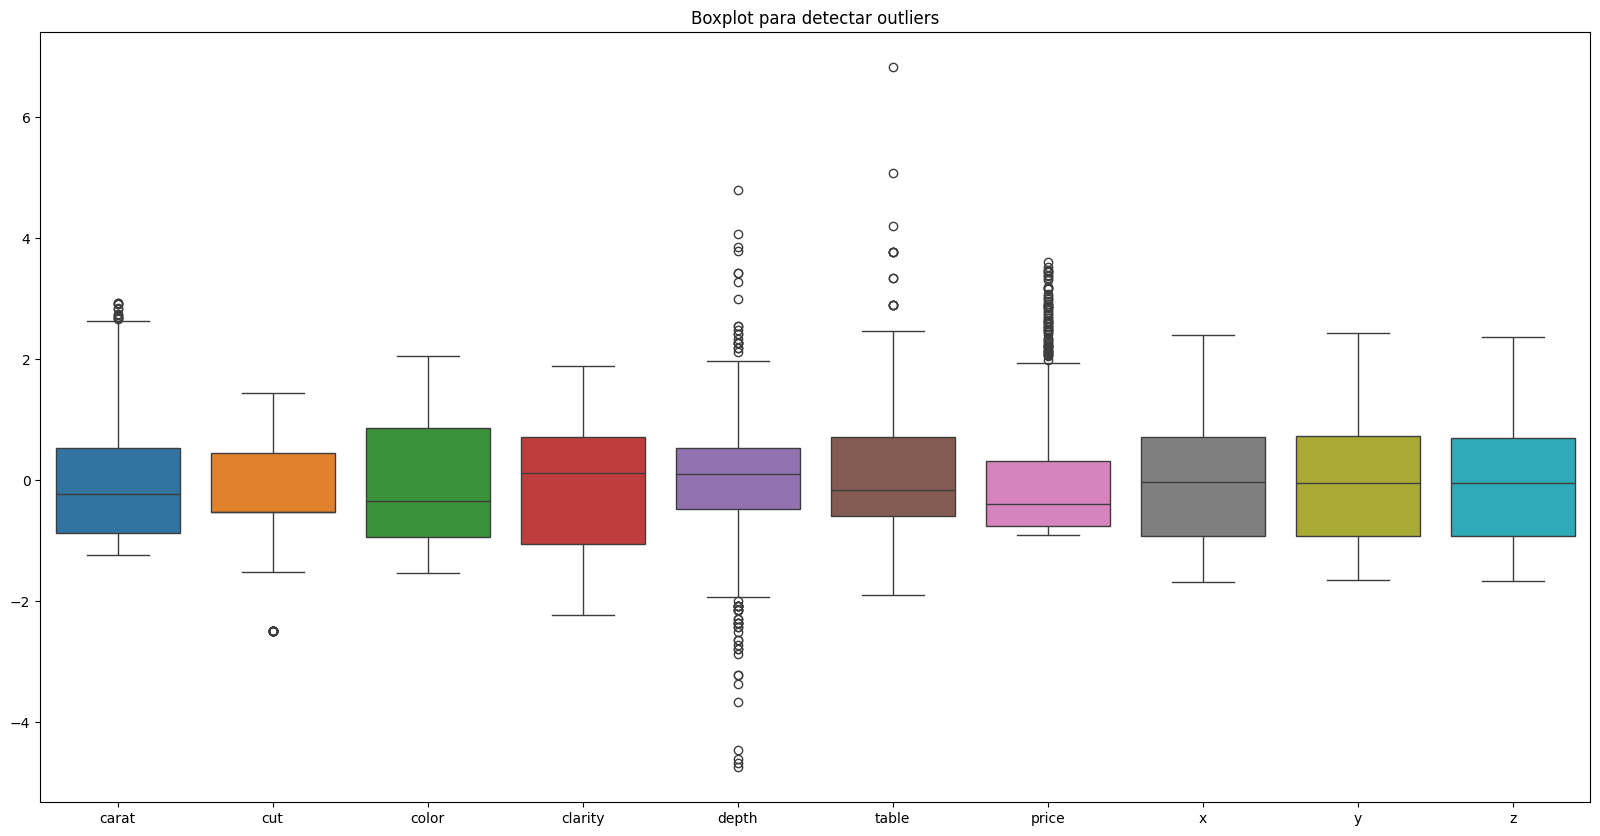

In [51]:

df_3_scaled = pd.DataFrame(standar_scaler.fit_transform(df_3), columns=df_3.columns)

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_3_scaled)
plt.title('Boxplot para detectar outliers')

In [52]:
#! PARA EVITAR CONFLICTO, seguiremos haciendo las pruebas con la X y la y original, DONDE SE MANTIENEN LOS OUTLIERS

#TODO Elige de qué manera quieres escalar los datos
scaler = StandardScaler()
#scaler = MinMaxScaler()

#Escalamos todo menos los categóricos
X_estandar = scaler.fit_transform(df_2.drop(target, axis=1))

#Añadimos la columna categórica
X_estandar = pd.concat([df_2, df_2[target]], axis=1)

#Comprobamos que se ha escalado correctamente
print(X_estandar.head())

calc_predictions(X_estandar, y)



       carat  cut  color  clarity  depth  table  price     x     y     z  \
1388    0.24    2    3.0      6.0   62.1   56.0    559  3.97  4.00  2.47   
50052   0.58    4    2.0      7.0   60.0   57.0   2201  5.44  5.42  3.26   
41645   0.40    2    1.0      7.0   62.1   55.0   1238  4.76  4.74  2.95   
42377   0.43    3    1.0      7.0   60.8   57.0   1304  4.92  4.89  2.98   
17244   1.55    2    1.0      3.0   62.3   55.0   6901  7.44  7.37  4.61   

       outlier  cut  
1388         1    2  
50052        1    4  
41645        1    2  
42377        1    3  
17244        1    2  


c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.944,0.759078,0.771667,0.938333
1,KNeighborsClassifier,0.388,0.242796,0.226131,0.355063
2,DecisionTreeClassifier,1.000,1.000000,1.000000,1.000000
3,RandomForestClassifier,1.000,1.000000,1.000000,1.000000
4,SVC,0.404,0.233102,0.187603,0.290992


### Eliminacion de features poco relevantes

Utilizaremos SelectKBest -sabiendo que podemos utilizar árboles de decisión o RFE. 
Con SelectKBest hay distintos métodos dependiendo de si son datos continuos, categóricos, numéricos... Por defecto el sistema es ANOVA, que se basa en la varianza.

In [53]:
df_2.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z,outlier
count,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,0.827500,2.534000,2.56700,3.78200,61.759700,57.368800,4165.147000,5.80121,5.800870,3.580360,0.980000
std,0.490193,1.022688,1.67998,1.70921,1.401489,2.303578,4190.104476,1.14740,1.142003,0.700021,0.199097
min,0.230000,0.000000,0.00000,0.00000,55.200000,53.000000,360.000000,3.89000,3.930000,2.430000,-1.000000
25%,0.410000,2.000000,1.00000,2.00000,61.100000,56.000000,1007.000000,4.74000,4.750000,2.950000,1.000000
50%,0.710000,2.000000,2.00000,4.00000,61.900000,57.000000,2542.500000,5.74500,5.750000,3.550000,1.000000
75%,1.080000,3.000000,4.00000,5.00000,62.500000,59.000000,5569.750000,6.60000,6.600000,4.060000,1.000000
max,2.750000,4.000000,6.00000,7.00000,68.400000,73.000000,18803.000000,9.04000,8.980000,5.490000,1.000000


In [54]:
df_selectkbest = df_2.drop([target, 'outlier'], axis=1).columns

# Seleccionar las K mejores características utilizando ANOVA F-value (por defecto)
selector = SelectKBest(k=3)
X_selectkbest = selector.fit_transform(X, y)


# Obtener los nombres de las características seleccionadas
mask = selector.get_support() 
selected_features = df_selectkbest[mask] 
print("Selected features:", selected_features)


calc_predictions(X_selectkbest, y)

Selected features: Index(['depth', 'table', 'x'], dtype='object')


c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.576,0.359475,0.348974,0.545211
1,KNeighborsClassifier,0.648,0.529192,0.570123,0.618107
2,DecisionTreeClassifier,0.596,0.576009,0.587330,0.594509
3,RandomForestClassifier,0.672,0.607400,0.644974,0.663320
4,SVC,0.708,0.595710,0.620572,0.679127


### Creación de nuevas features - PCA

In [55]:
# Aplicar PCA
pca = PCA(n_components=2)  # Queremos reducir a 2 componentes principales
X_pca = pca.fit_transform(X)

# CREAR UN DATAFRAME CON LOS COMPONENTES PRINCIPALES
df_pca = pd.DataFrame(data=X_pca, columns=['componente_1', 'componente_2'])
df_pca['Target'] = y
 
print(df_pca.head())

calc_predictions(X_pca, y)


   componente_1  componente_2  Target
0  -3606.147982     -1.352638     NaN
1  -1964.147256      0.084947     NaN
2  -2927.147896     -2.373510     NaN
3  -2861.147614     -0.091815     NaN
4   2735.853451     -2.484868     NaN


c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.592,0.334992,0.287875,0.502299
1,KNeighborsClassifier,0.392,0.244924,0.226311,0.356637
2,DecisionTreeClassifier,0.484,0.385438,0.375577,0.485099
3,RandomForestClassifier,0.540,0.337521,0.331911,0.518809
4,SVC,0.376,0.213309,0.175582,0.295308


### Distribución de los datos - QuantileTransform

En caso de que queramos que los datos sigan una distribución normal, aplicaremos el QuantileTransform.

               model_name  accuracy    recall  f1_score  overall_f1_score
0      LogisticRegression     0.604  0.431880  0.448651          0.578538
1    KNeighborsClassifier     0.580  0.419963  0.415258          0.541031
2  DecisionTreeClassifier     0.608  0.618299  0.630523          0.612671
3  RandomForestClassifier     0.680  0.595910  0.640523          0.669160
4                     SVC     0.624  0.553721  0.540911          0.611204


<Axes: xlabel='price', ylabel='Count'>

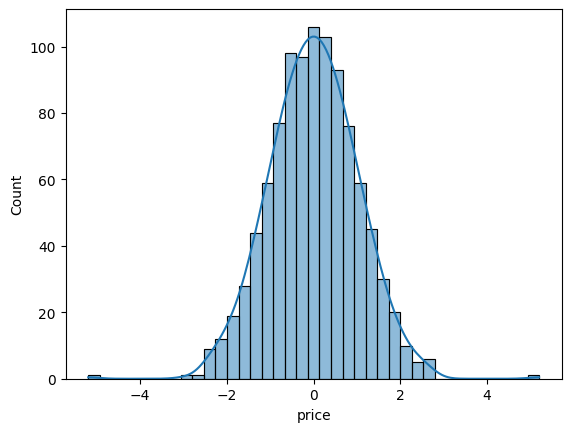

In [60]:

transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=42)

# Ajustar y transformar los datos
df_transformed = transformer.fit_transform(df_2)

# Convertir de nuevo a DataFrame para facilitar la visualización
df_transformed = pd.DataFrame(df_transformed, columns=df_2.columns)

X_trans = df_transformed.drop(target, axis=1)
y_trans = df[target]

print(calc_predictions(X_trans,y_trans))

#TODO NO ELIJAS EL TARGET, ELIGE OTRA CARACTERÍSTICA DIFERENTE Y QUE SEA RELEVANTE
sns.histplot(df_transformed['price'], kde=True)


### Discretización de datos - KbinsDiscretizer

Para realizar este paso será necesario conocer bien nuestro dataset y ver qué datos podemos discretizar, si es que hay algún rango que nos interese crear. 

In [64]:
#
#TODO NO ELIJAS EL TARGET, ELIGE OTRA CARACTERÍSTICA DIFERENTE Y QUE SEA RELEVANTE

column_to_discretize= 'price'
X[column_to_discretize]

1388      559
50052    2201
41645    1238
42377    1304
17244    6901
         ... 
35207     891
15806    6324
45884    1719
22681     629
21429    9537
Name: price, Length: 1000, dtype: int64

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               model_name  accuracy    recall  f1_score  overall_f1_score
0      LogisticRegression     0.552  0.310913  0.266599          0.464430
1    KNeighborsClassifier     0.388  0.242796  0.225344          0.354232
2  DecisionTreeClassifier     0.608  0.606348  0.600763          0.610940
3  RandomForestClassifier     0.672  0.588993  0.629947          0.658813
4                     SVC     0.376  0.211780  0.158781          0.257973


<Axes: xlabel='price', ylabel='Count'>

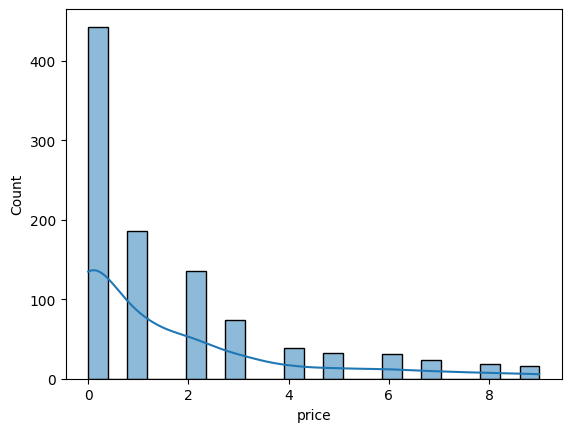

In [65]:
# Crear el discretizador
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')


X_disc = X.copy()

#Modificamos los valores de la columna que queramos discretizar
X_disc[column_to_discretize] = discretizer.fit_transform(X_disc[[column_to_discretize]])

print(calc_predictions(X,y))

#Visualizamos la columna discretizada
sns.histplot(X_disc[column_to_discretize], kde=True)


# Modelado y entrenamiento del modelo

En esta fase procedemos directamente a entrenar el modelo teniendo en cuenta los pasos más convenientes. Para ello, utilizaremos un Pipeline de CLASIFICACIÓN.

In [66]:
df_copy.describe()

,carat,depth,table,price,x,y,z
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,0.827500,61.759700,57.368800,4165.147000,5.80121,5.800870,3.580360
std,0.490193,1.401489,2.303578,4190.104476,1.14740,1.142003,0.700021
min,0.230000,55.200000,53.000000,360.000000,3.89000,3.930000,2.430000
25%,0.410000,61.100000,56.000000,1007.000000,4.74000,4.750000,2.950000
50%,0.710000,61.900000,57.000000,2542.500000,5.74500,5.750000,3.550000
75%,1.080000,62.500000,59.000000,5569.750000,6.60000,6.600000,4.060000
max,2.750000,68.400000,73.000000,18803.000000,9.04000,8.980000,5.490000


### 1. Creación de Pipeline de CLASIFICACIÓN

In [74]:
#TODO Adapta esta parte y asegúrate de que la 'y' tiene todos los valores
#y.isnull().sum()
y = df_copy[target]
X = df_copy.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#! QUITA EL TARGET DE X_TRAIN Y X_TEST, QUE TE VA A DAR ERROR EN EL PIPELINE
categorical_features = [feature for feature in categorical_features if feature != target]
numerical_features
categorical_features

['color', 'clarity']

In [75]:

# TODO Aplicar IsolationForest e IQR antes de empezar con el pipeline (si es necesario)
# TODO Aplicar LabelEncoder a la columna categórica
# TODO Aplicar discretizer a la columna que se quiera discretizar antes del pipeline


# Crear el pipeline de preprocesamiento para numéricos
pipeline_num = Pipeline([
    ('imputer_iterative', IterativeImputer()),
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(k=3)),
    ('pca', PCA(n_components=2)),
    ('quantile_transformer', QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=0))
])

# columnas categoricas
pipeline_cat = Pipeline([
    ("imputer_constant", SimpleImputer(strategy='most_frequent')),
     ("encoder", OrdinalEncoder()),
    
])

preprocessor = ColumnTransformer([
    ("numeric", pipeline_num, numerical_features ),
    ("categorical", pipeline_cat, categorical_features)
])

preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer_iterative',
                                                  IterativeImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('select_kbest',
                                                  SelectKBest(k=3)),
                                                 ('pca', PCA(n_components=2)),
                                                 ('quantile_transformer',
                                                  QuantileTransformer(n_quantiles=100,
                                                                      output_distribution='normal',
                                                                      random_state=0))]),
                                 ['carat', 'depth', 'table', 'price', 'x', 'y',
                                  'z']),
                                ('categorical',
                                 Pipeline(steps=[('imputer_constant',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['color', 'clarity'])])

### 2. Métricas de evaluación para el Pipeline de Clasificación

In [76]:
def calc_predictions_pipeline(model, X_train, y_train, X_test, y_test):
    df_results = pd.DataFrame(
        columns=['model_name', 'accuracy', 'precision', 'recall_sensitivity', 'recall_specificity', 'f1'])
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    # classification metrics
    model_name = model.__class__.__name__
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall_sensitivity = recall_score(y_test, y_pred, average='micro')
    recall_specificity = recall_score(y_test, y_pred, pos_label=0, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')


    # guardar resultados
    row = [model_name, accuracy, precision, recall_sensitivity, recall_specificity, f1]
    df_results.loc[len(df_results)] = row
    return df_results

### 3. Evaluamos las métricas de nuestro pipeline

In [82]:
# Transformar los datos de entrenamiento y de prueba
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

df_evaluation = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall_sensitivity', 'recall_specificity', 'f1'])

#TODO ELEGIR LOS MODELOS QUE SE VAYAN A USAR Y CONCATENARLOS AL FINAL DEL TODO

# Modelo 1: KNeighborsClassifier
knn_model = KNeighborsClassifier(weights='distance')
knn_model.fit(X_train_preprocessed, y_train)
knn_eval = calc_predictions_pipeline(knn_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_knn_pred = knn_model.predict(X_test_preprocessed)

# Modelo 2: RandomForestClassifier
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train_preprocessed, y_train)
rf_eval = calc_predictions_pipeline(rf_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_rf_pred = pd.DataFrame(rf_model.predict(X_test_preprocessed))

# Modelo 3: DecissionTree 
dt_model = DecisionTreeClassifier(max_depth=2, class_weight='balanced') #TODO Decidir profunidad del arbol
dt_model.fit(X_train_preprocessed, y_train)
dt_eval = calc_predictions_pipeline(dt_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_dt_pred = pd.DataFrame(dt_model.predict(X_test_preprocessed))


# Modelo 4: AdaBoost
ada_model = AdaBoostClassifier(estimator=dt_model, n_estimators=50, learning_rate=1.0)
ada_model.fit(X_train_preprocessed, y_train)
ada_eval = calc_predictions_pipeline(ada_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_ada_pred = pd.DataFrame(ada_model.predict(X_test_preprocessed))


df_evaluation = pd.concat([df_evaluation, knn_eval, rf_eval, dt_eval, ada_eval], axis=0)

df_evaluation

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1569: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1569: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1569: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Lo

,model_name,accuracy,precision,recall_sensitivity,recall_specificity,f1
0,KNeighborsClassifier,0.445,0.445,0.445,0.445,0.445
0,RandomForestClassifier,0.520,0.520,0.520,0.520,0.520
0,DecisionTreeClassifier,0.375,0.375,0.375,0.375,0.375
0,AdaBoostClassifier,0.350,0.350,0.350,0.350,0.350


### 4. Dibujamos los residuos de cada modelo

Text(0.5, 1.0, 'AdaBoost')

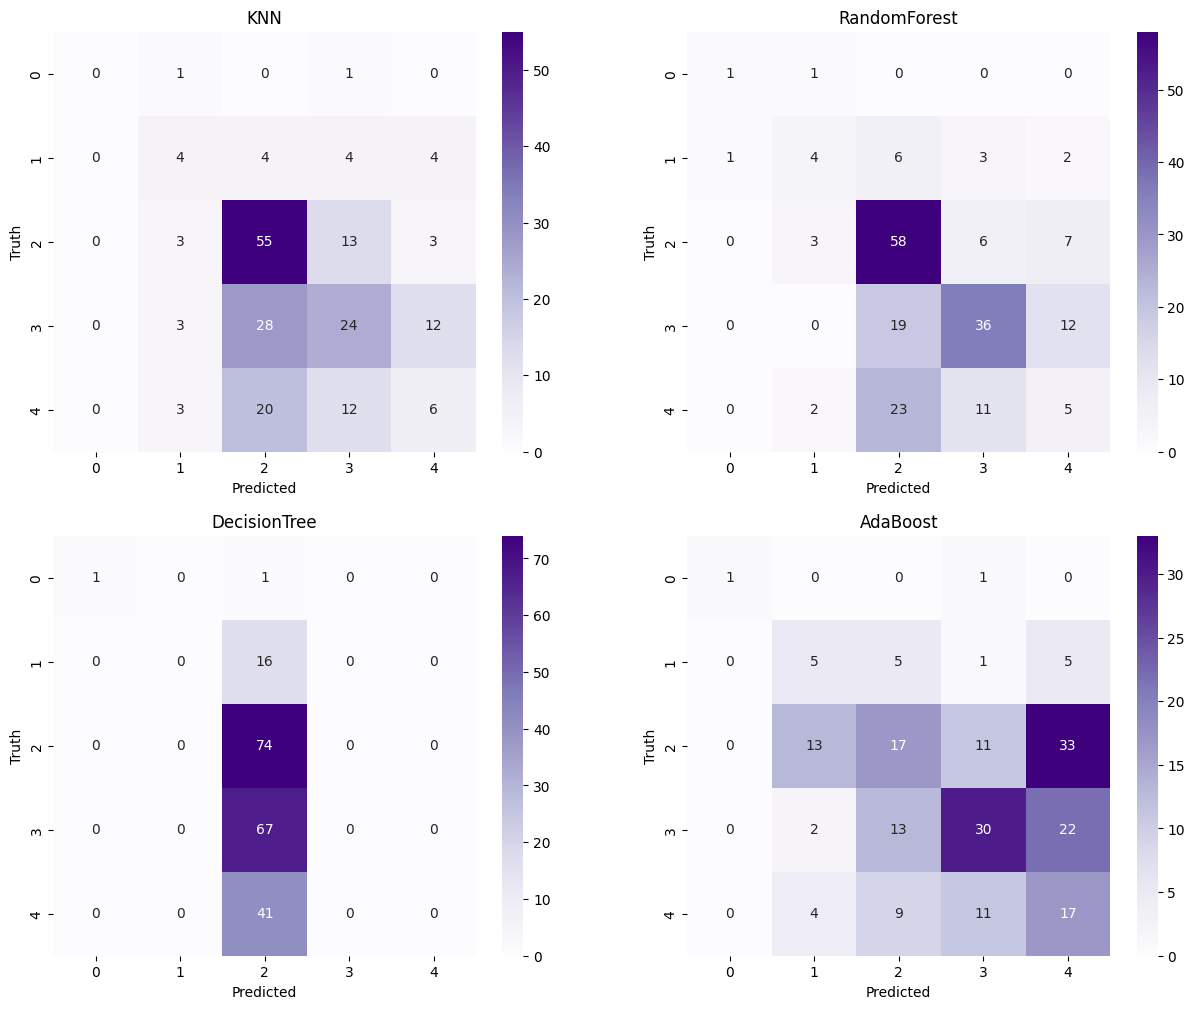

In [84]:
matrix_knn = confusion_matrix(y_test, y_knn_pred)
matrix_rf = confusion_matrix(y_test, y_rf_pred)
matrix_dt = confusion_matrix(y_test, y_dt_pred)
matrix_ada = confusion_matrix(y_test, y_ada_pred)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the size to fit all plots

# Dibujar la matriz de confusión para KNN
sns.heatmap(matrix_knn, annot=True, fmt='d', ax=axs[0][0], cmap='Purples')
axs[0][0].set_xlabel('Predicted')
axs[0][0].set_ylabel('Truth')
axs[0][0].set_title('KNN')

# Dibujar la matriz de confusión para RandomForest
sns.heatmap(matrix_rf, annot=True, fmt='d', ax=axs[0][1], cmap='Purples')
axs[0][1].set_xlabel('Predicted')
axs[0][1].set_ylabel('Truth')
axs[0][1].set_title('RandomForest')

# Dibujar la matriz de confusión para DecisionTree
sns.heatmap(matrix_dt, annot=True, fmt='d', ax=axs[1][0], cmap='Purples')
axs[1][0].set_xlabel('Predicted')
axs[1][0].set_ylabel('Truth')
axs[1][0].set_title('DecisionTree')

# Dibujar la matriz de confusión para AdaBoost
sns.heatmap(matrix_ada, annot=True, fmt='d', ax=axs[1][1], cmap='Purples')
axs[1][1].set_xlabel('Predicted')
axs[1][1].set_ylabel('Truth')
axs[1][1].set_title('AdaBoost')



## Keras y clasificación multiclase

Para utilizar una red neuronal, sigue los siguientes pasos:
1. Crea el modelo con Keras usando su arquitectura.
2. Compila el modelo -model.compile.
3. Entreanmiento -model.fit
4. Observa lo que haya salido del modelo: model.sumary()
5. Pintar el error -sns.lineplot()
6. Evaluación del modelo
7. Realiza predicciones.

In [95]:
y_train = LabelEncoder().fit_transform(y_train)
y_test  = LabelEncoder().fit_transform(y_test)

In [89]:
kr = tf.keras

keras_model_clas = kr.Sequential([
     kr.layers.Dense(10, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(5, activation='softmax') #!En la capa de salida preocúpate de que el número de neuronas sea igual al número de clases
])

# Antes de usar Keras, hay que asegurarnos de que los datos tienen cierta forma en la entrada
X_train.shape

keras_model_clas.compile(optimizer=kr.optimizers.Adam(learning_rate=0.01),
              loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

keras_model_clas.fit(X_train_preprocessed, y_train, epochs=50, validation_split=0.2)

Epoch 1/50


c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2092 - loss: 1.8916 - val_accuracy: 0.4187 - val_loss: 1.5156
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4206 - loss: 1.5016 - val_accuracy: 0.3875 - val_loss: 1.4221
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4252 - loss: 1.4322 - val_accuracy: 0.3938 - val_loss: 1.3596
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4027 - loss: 1.3840 - val_accuracy: 0.3938 - val_loss: 1.3603
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3950 - loss: 1.3708 - val_accuracy: 0.4437 - val_loss: 1.2978
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5013 - loss: 1.2629 - val_accuracy: 0.4812 - val_loss: 1.2681
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5019 - loss: 1.2230 - val_accuracy: 0.5063 - val_loss: 1.2625
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5053 - loss: 1.1883 - val_accuracy: 0.4500 - val_loss: 1.3469
Ep

## Evaluación

In [96]:
%pip install graphviz, pydot

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'graphviz,'

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [97]:
kr.utils.plot_model(keras_model_clas, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [98]:
keras_model_clas.history.history

{}

<Axes: >

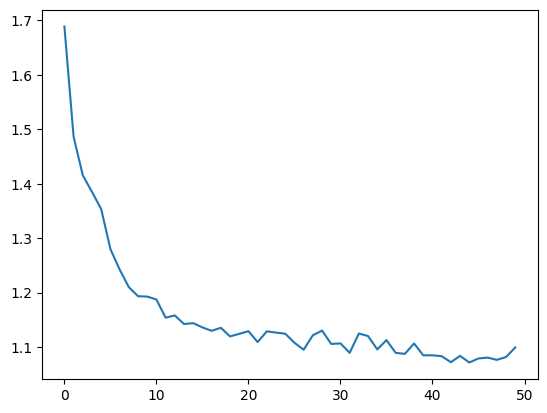

In [92]:
mse = keras_model_clas.history.history['loss']
sns.lineplot(x=range(len(mse)), y=mse)

In [99]:
training_score = keras_model_clas.evaluate(X_train_preprocessed, y_train)
test_score = keras_model_clas.evaluate(X_test_preprocessed, y_test)

print(keras_model_clas.metrics_names)
print('training_score', training_score)
print('test_score', test_score)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5477 - loss: 1.0937  


c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5653 - loss: 1.1074  
['loss', 'compile_metrics']
training_score [1.0995064973831177, 0.5362499952316284]
test_score [1.1100562810897827, 0.5299999713897705]


In [100]:
y_pred = keras_model_clas.predict(X_test_preprocessed)
y_pred = np.argmax(y_pred, axis=-1) #La predicción genera distintos pesos que suman 1, con esto se queda simplificado a un array
y_pred

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([3, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2,
       3, 2, 2, 3, 2, 2, 3, 2, 2, 4, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       2, 3, 2, 2, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 1, 3, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 1, 3, 2, 3,
       2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3,
       3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2,
       3, 2], dtype=int64)

In [101]:

df_results = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred.ravel()
})
df_results.head()

,y_test,y_pred
0,4,3
1,1,1
2,2,2
3,2,2
4,4,2


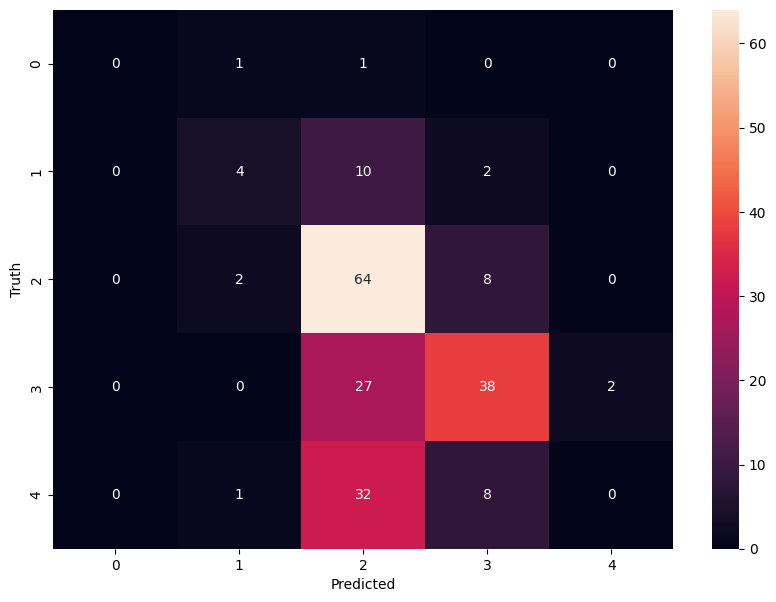

In [102]:

#TODO PINTAMOS UNA MATRIZ DE CONFUSIÓN

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Dibujar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [103]:
df_results['error'] = df_results['y_test'] - df_results['y_pred']
df_results.head(20)

,y_test,y_pred,error
0,4,3,1
1,1,1,0
2,2,2,0
3,2,2,0
4,4,2,2
5,1,1,0
6,2,2,0
7,4,2,2
8,2,2,0
9,2,2,0
